# **Music and Speech classification using CNN**

# Data preprocessing and loading notebook


**Data:**

Gtzan dataset, 64 of 30 sec samples, for each
Fourier transformed to 2d map of amplitudes for frequency vs time


**Aim:**

-create 64 time-samples long patches with overlap of 32 from all music and speech files. assign labels accordingly

# **Load libraries and setting paths, testing examples**

In [134]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
from torchvision import transforms
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import IPython.display as ipd
import pickle

import requests
import urllib.request
from urllib.request import urlopen
from urllib.parse import urljoin
from io import BytesIO

import numpy as np
#from IPython.display import display

Set path to source wavs on public Github:

In [136]:
gtzan_url = "https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/"

Lets' hear few samples:

In [137]:
audio_url = "https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/bagpipe.wav"
ipd.Audio(audio_url) #play audio_file directly from URL

# **Dataset construction and data augmentation**:
We construct 3 fourier transform mel spectrogram patches from each file: 64 times long patches with 32 time overlap for each audio file and label the patches accordingly.

Then we load the spectrograms, patches, labels and audio_paths into a tensor

In [138]:
# Define a transform to convert audio to a mel spectrogram
transform = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=400, hop_length=160, n_mels=64),
    transforms.Resize((128, 128), antialias=True),
])

# Construct patches for all the spectrograms
patch_length = 64
overlap = 32

def extract_patches(spectrogram, patch_length=patch_length, overlap=overlap):
    patches = []
    for start in range(0, spectrogram.size(2) - patch_length + 1, overlap):
        end = start + patch_length
        patch = spectrogram[:, :, start:end]
        patches.append(patch)
    return torch.stack(patches, dim=0)

def load_audio_from_url(file_url):
    response = requests.get(file_url)
    if response.status_code != 200:
        print(f"Failed to fetch audio file {file_url}. Status code: {response.status_code}")
        return None, None

    try:
        audio_data, sample_rate = torchaudio.load(BytesIO(response.content))
        return audio_data, sample_rate
    except Exception as e:
        print(f"Error loading audio file {file_url}: {e}")
        return None, None

def load_gtzan_dataset(gtzan_url):
    all_patches = []
    all_labels = []
    all_spectrograms = []
    all_audio_paths = []

    # Fixed lists of filenames for each class
    music_filenames = ["music_wav/bagpipe.wav", "music_wav/ballad.wav", "music_wav/bartok.wav","music_wav/beat.wav","music_wav/beatles.wav","music_wav/bigband.wav","music_wav/birdland.wav","music_wav/blues.wav","music_wav/bmarsalis.wav","music_wav/brahms.wav","music_wav/canonaki.wav","music_wav/caravan.wav","music_wav/chaka.wav","music_wav/classical.wav","music_wav/classical1.wav","music_wav/classical2.wav","music_wav/copland.wav","music_wav/copland2.wav","music_wav/corea.wav","music_wav/corea1.wav","music_wav/cure.wav","music_wav/debussy.wav","music_wav/deedee.wav","music_wav/deedee1.wav","music_wav/duke.wav","music_wav/echoes.wav","music_wav/eguitar.wav","music_wav/georose.wav","music_wav/gismonti.wav","music_wav/glass.wav","music_wav/glass1.wav","music_wav/gravity.wav","music_wav/gravity2.wav","music_wav/guitar.wav","music_wav/hendrix.wav","music_wav/ipanema.wav","music_wav/jazz.wav","music_wav/jazz1.wav","music_wav/led.wav","music_wav/loreena.wav","music_wav/madradeus.wav","music_wav/magkas.wav","music_wav/march.wav","music_wav/marlene.wav","music_wav/mingus.wav","music_wav/mingus1.wav","music_wav/misirlou.wav","music_wav/moanin.wav","music_wav/narch.wav","music_wav/ncherry.wav","music_wav/nearhou.wav","music_wav/opera.wav","music_wav/opera1.wav","music_wav/pop.wav","music_wav/prodigy.wav","music_wav/redhot.wav","music_wav/rock.wav","music_wav/rock2.wav","music_wav/russo.wav","music_wav/tony.wav","music_wav/u2.wav","music_wav/unpoco.wav","music_wav/vlobos.wav","music_wav/winds.wav"]
    speech_filenames = ["speech_wav/acomic.wav", "speech_wav/acomic2.wav", "speech_wav/allison.wav", "speech_wav/amal.wav", "speech_wav/austria.wav","speech_wav/bathroom1.wav","speech_wav/chant.wav","speech_wav/charles.wav","speech_wav/china.wav","speech_wav/comedy.wav","speech_wav/comedy1.wav","speech_wav/conversion.wav","speech_wav/danie.wav","speech_wav/danie1.wav","speech_wav/dialogue.wav","speech_wav/dialogue1.wav","speech_wav/dialogue2.wav","speech_wav/diamond.wav","speech_wav/ellhnika.wav","speech_wav/emil.wav","speech_wav/fem_rock.wav","speech_wav/female.wav","speech_wav/fire.wav","speech_wav/geography.wav","speech_wav/geography1.wav","speech_wav/georg.wav","speech_wav/god.wav","speech_wav/greek.wav","speech_wav/greek1.wav","speech_wav/india.wav","speech_wav/jony.wav","speech_wav/jvoice.wav","speech_wav/kedar.wav","speech_wav/kid.wav","speech_wav/lena.wav","speech_wav/male.wav","speech_wav/my_voice.wav","speech_wav/nether.wav","speech_wav/news1.wav","speech_wav/news2.wav","speech_wav/nj105.wav","speech_wav/nj105a.wav","speech_wav/oneday.wav","speech_wav/psychic.wav","speech_wav/pulp.wav","speech_wav/pulp1.wav","speech_wav/pulp2.wav","speech_wav/relation.wav","speech_wav/serbian.wav","speech_wav/shannon.wav","speech_wav/sleep.wav","speech_wav/smoke1.wav", "speech_wav/smoking.wav", "speech_wav/stupid.wav", "speech_wav/teachers.wav", "speech_wav/teachers1.wav", "speech_wav/teachers2.wav", "speech_wav/thlui.wav", "speech_wav/undergrad.wav", "speech_wav/vegetables.wav", "speech_wav/vegetables1.wav", "speech_wav/vegetables2.wav", "speech_wav/voice.wav","speech_wav/voices.wav"]

    classes = [music_filenames, speech_filenames]
    class_labels = [0, 1]

    for label, filenames in zip(class_labels, classes):
        for filename in filenames:
            print (filename)
            file_url = urljoin(gtzan_url, filename)

            # Load audio file
            audio_data, sample_rate = load_audio_from_url(file_url)
            if audio_data is None:
                continue

            # Apply the defined transform to get the spectrogram
            spectrogram = transform(audio_data)

            # Extract patches
            patches = extract_patches(spectrogram, patch_length=int(patch_length), overlap=int(overlap))

            # Append patches and labels
            if len(patches) > 0:
                all_patches.append(patches)
                all_labels.append(torch.tensor([label] * len(patches)))
                all_spectrograms.append(spectrogram)

                # Append audio path
                all_audio_paths.extend([file_url] * len(patches))

    if not all_patches:
        raise RuntimeError("No valid patches found in the dataset.")

    return (
        torch.cat(all_patches, dim=0),
        torch.cat(all_labels, dim=0),
        torch.stack(all_spectrograms, dim=0),
        all_audio_paths
    )


# Call the function to construct the dataset
patches, labels, spectrograms, audio_paths = load_gtzan_dataset(gtzan_url)

# Print the shape of the tensors and the tensors
print(f'Patches shape: {patches.shape}')
print(f'Labels shape: {labels.shape}')
#print (labels)
print(f'Spectrograms shape: {spectrograms.shape}')

# Print the first 5 audio paths
print(f'First 5 audio paths: {audio_paths[:5]}')


Patches shape: torch.Size([384, 1, 128, 64])
Labels shape: torch.Size([384])
Spectrograms shape: torch.Size([128, 1, 128, 128])
First 5 audio paths: ['https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/bagpipe.wav', 'https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/bagpipe.wav', 'https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/bagpipe.wav', 'https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/ballad.wav', 'https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/ballad.wav']


# **Visualize few Spectrograms and Patches**
Print the Spectrogram, corresponding patches, the class (0 for music, 1 for speech) the  file path (to check correct labelling) and play audio.


Playing audio for: https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/bagpipe.wav


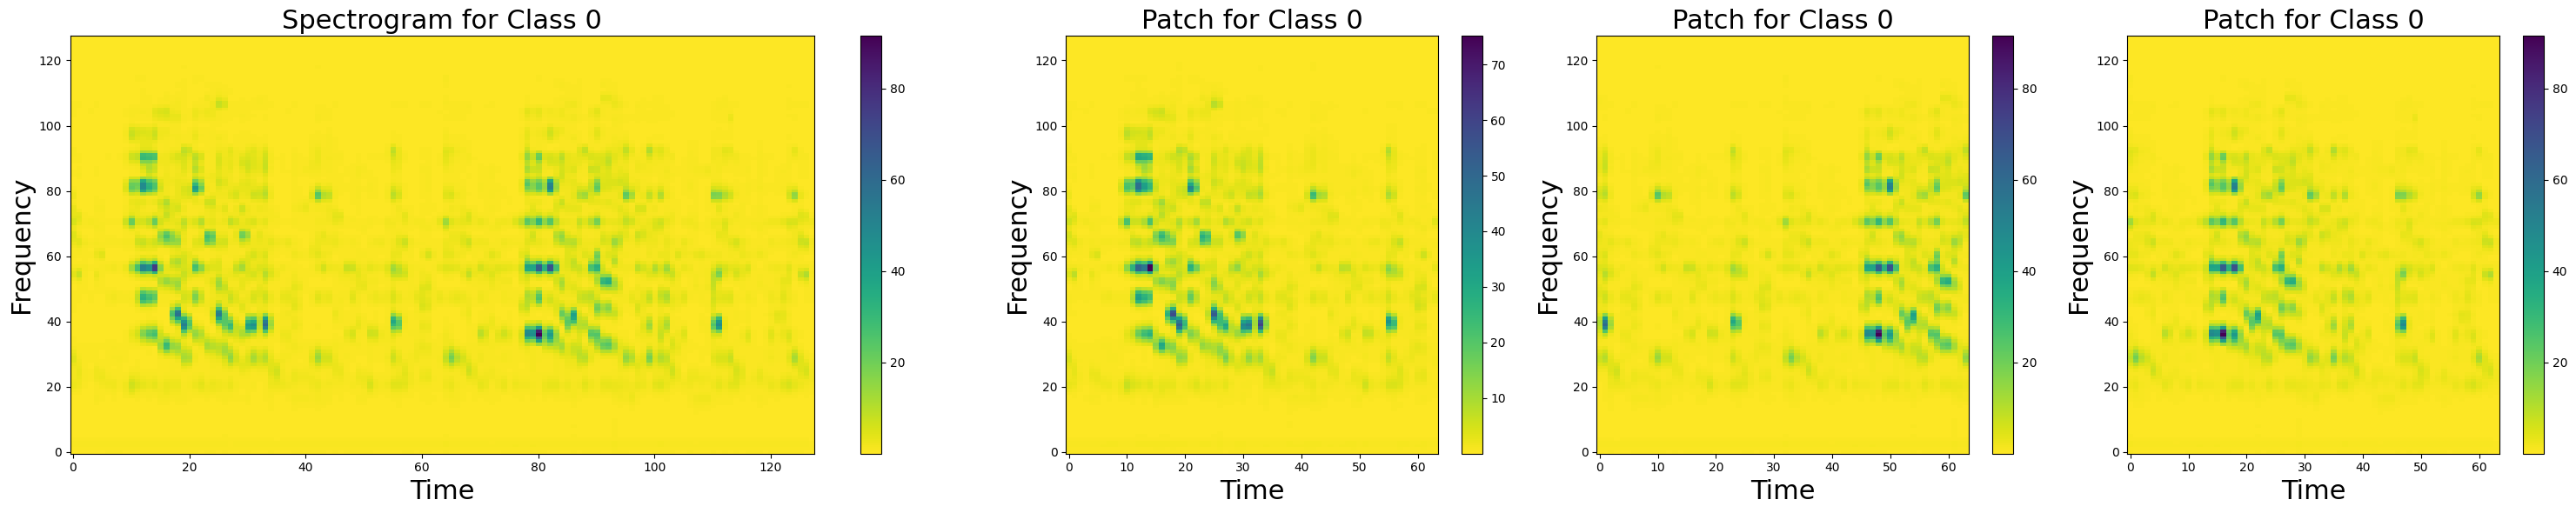

Playing audio for: https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/music_wav/classical2.wav


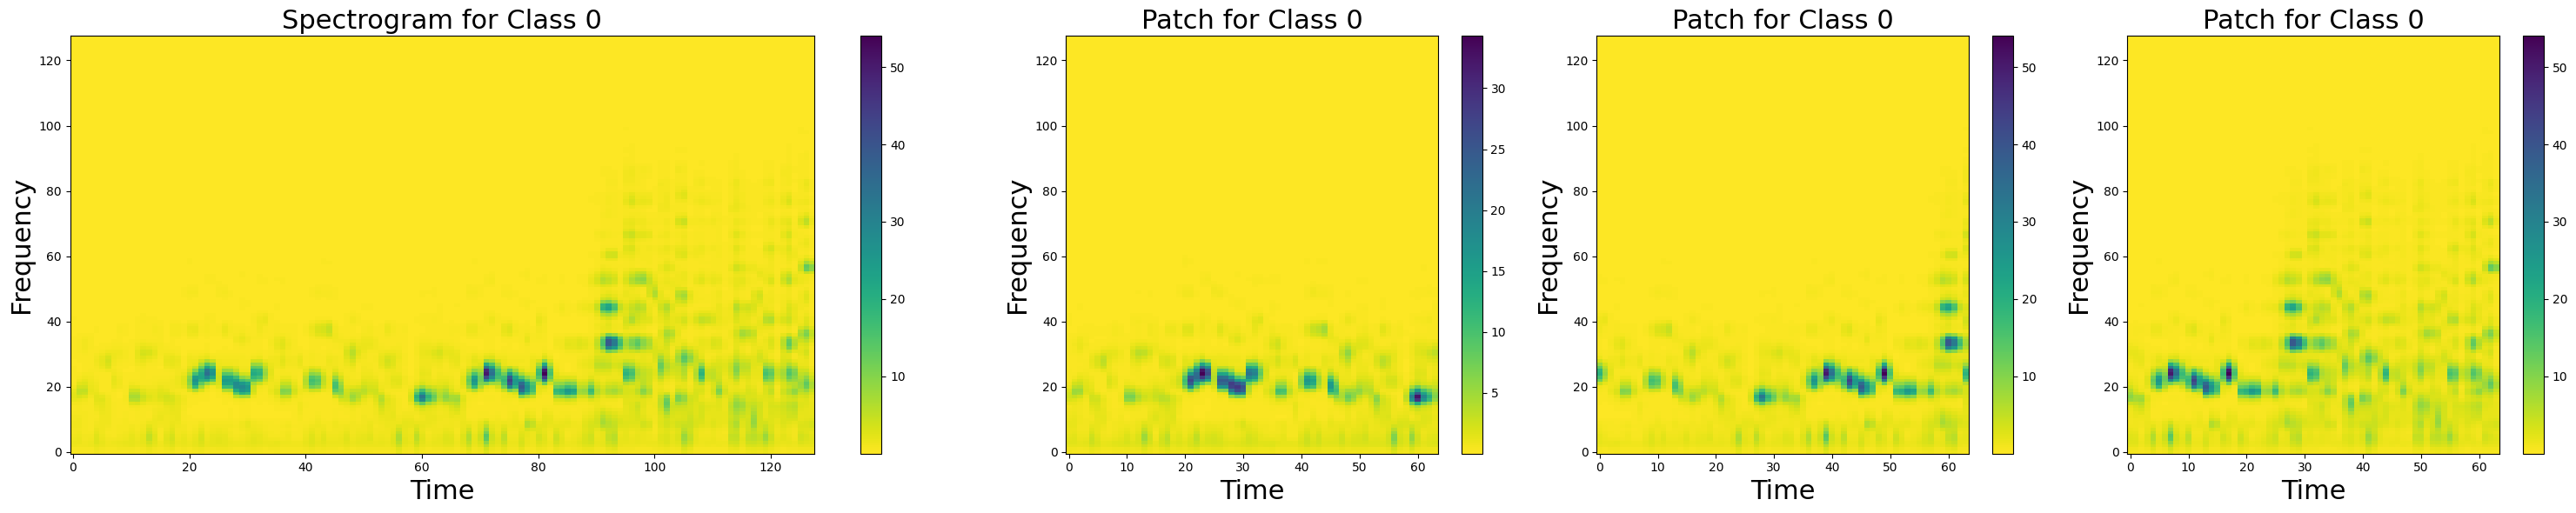

Playing audio for: https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/speech_wav/acomic2.wav


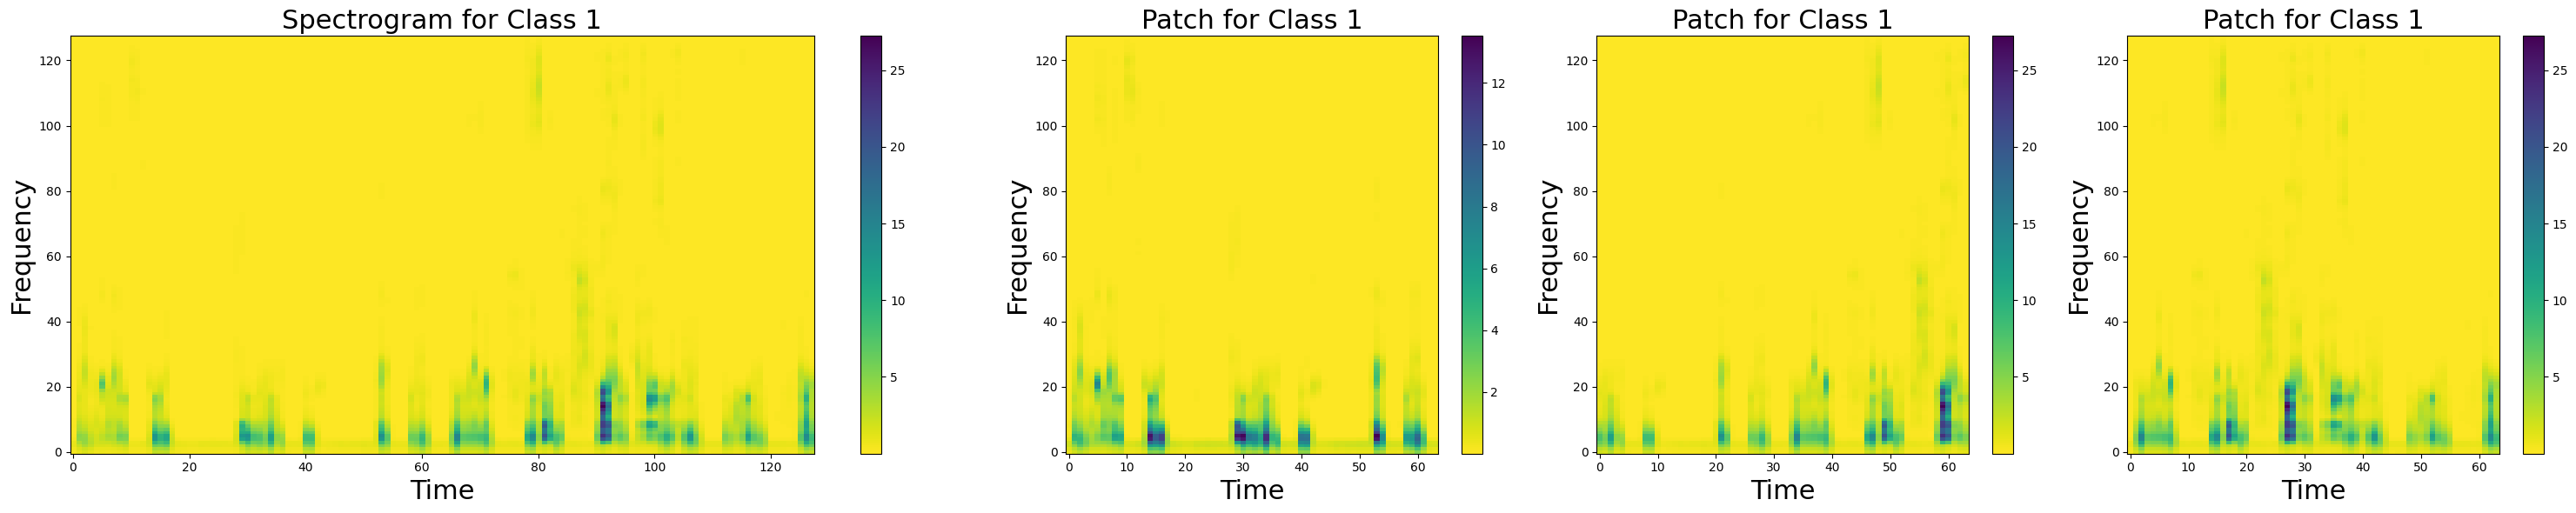

Playing audio for: https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/speech_wav/voices.wav


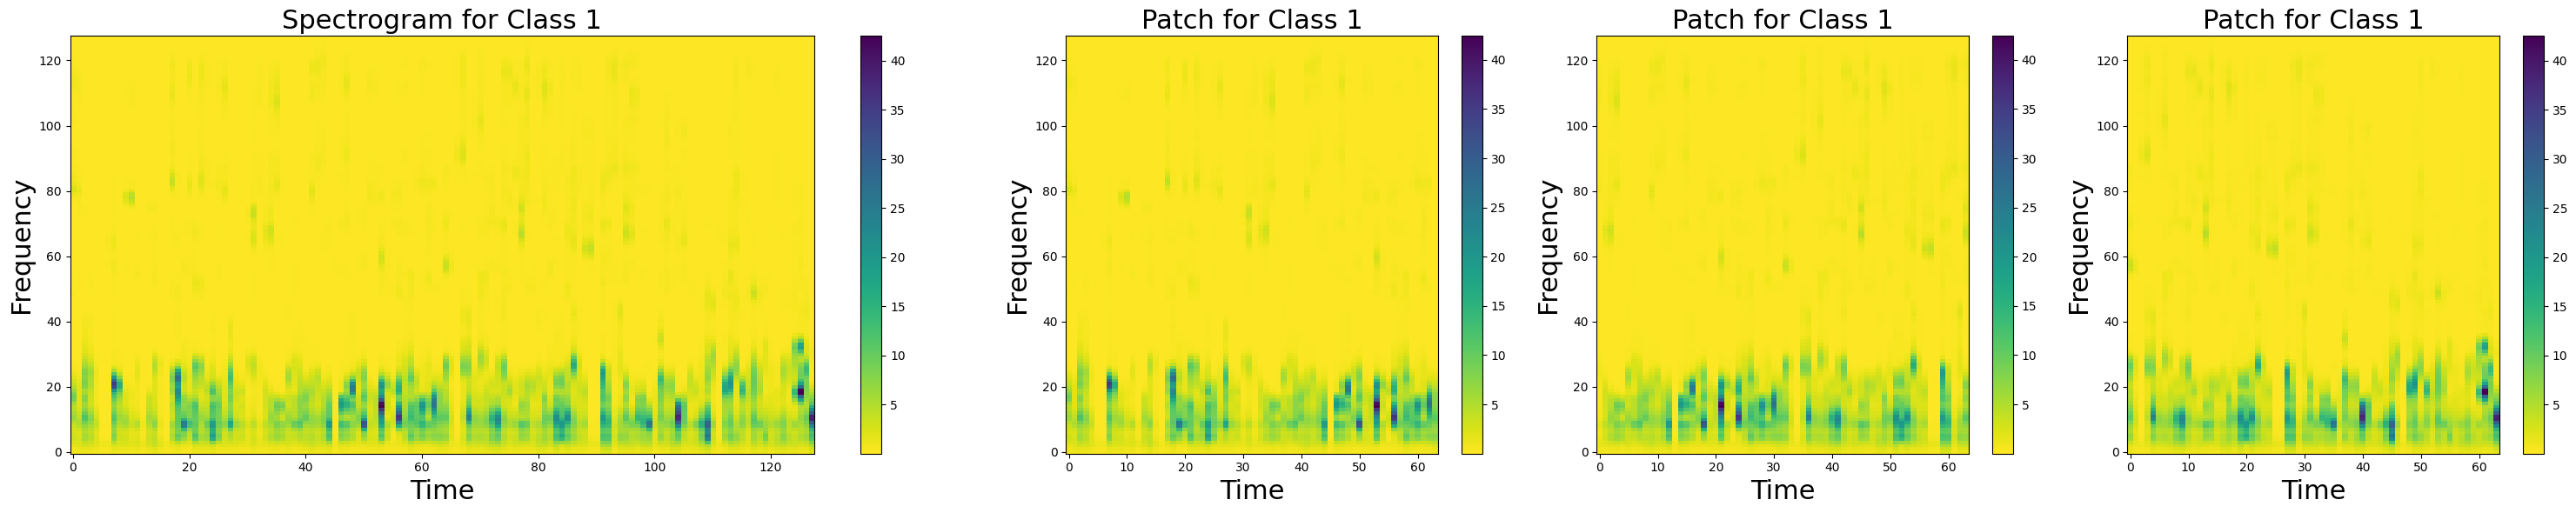

In [139]:
# Select a few indices for visualization (for this code should be called only as positive numbers)
visualize_indices = (0, 15, 65, 127)
width_ratios = (2,1,1,1)

# Plot the selected spectrograms and corresponding patches
for idx in visualize_indices:
    # Play audio
    print(f"Playing audio for: {audio_paths[idx*3]}") #play only the audio of the first pacth
    display(ipd.Audio(audio_paths[idx*3]))

    # Plot spectrogram and patches in the same row
    fig, axes = plt.subplots(1, 4, figsize=(30, 6), gridspec_kw={'width_ratios': width_ratios})

    # Plot spectrogram
    axes[0].imshow(spectrograms[idx][0].numpy(), cmap='viridis_r', aspect='auto', origin='lower')
    axes[0].set_title(f'Spectrogram for Class {labels[idx*3].item()}', fontsize= 22)
    axes[0].set_xlabel('Time',fontsize= 22)
    axes[0].set_ylabel('Frequency',fontsize= 22)
    axes[0].grid(False)
    plt.colorbar(axes[0].imshow(spectrograms[idx][0].numpy(), cmap='viridis_r', aspect='auto', origin='lower'), ax=axes[0])

    # Plot patches and play audio (indices of the patches are visualize indices of spectrograms * 3 and + 1,2 or 3 for the 3 patches)
    for i in range(3):
        axes[i+1].imshow(patches[idx*3+i][0].numpy(), cmap='viridis_r', aspect='auto', origin='lower')
        axes[i+1].set_title(f'Patch for Class {labels[idx*3+i].item()}',fontsize= 22)
        axes[i+1].set_xlabel('Time',fontsize= 22)
        axes[i+1].set_ylabel('Frequency',fontsize= 22)
        axes[i+1].grid(False)
        plt.colorbar(axes[i+1].imshow(patches[idx*3+i][0].numpy(), cmap='viridis_r', aspect='auto', origin='lower'), ax=axes[i+1])

    plt.tight_layout()
    plt.show()

# **Save the data tensor containing spectrograms, patches, labels and audio_paths to local disk and Google drive:**

In [ ]:
# 1. Mount Google Drive in Colab
drive.mount('/content/drive')
# Specify the path where you want to save the data on Google drive
local_save_path = '/content/drive/MyDrive/Module_6/saved_spectrograms_patches(32_overlap)_labels_paths.pkl'  # You can modify this path as needed (Matthias)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save all spectrograms, patches and labels using pickle
data = {'spectrograms': spectrograms, 'labels': labels, 'patches': patches, 'audio_paths': audio_paths}

with open(local_save_path, 'wb') as file:
    pickle.dump(data, file)

 #Download the saved file to your local machine => goes to downloads folder
files.download(local_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Old Loading Code, does not work anymore

In [ ]:
# OLD CODE WITH DYNAMIC LOADING FROM GITHUB (DOES NOT WORK ANYMORE)

gtzan_url = "https://github.com/Rinderkm/CAS-Github-Project/raw/main/Module_6_Deep_Learning/M6_Project/"

# Define a transform to convert audio to a mel spectrogram
transform = transforms.Compose([
   torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=400, hop_length=160, n_mels=64), #change the mels because there was an error
   transforms.Resize((128, 128),antialias=True),  # Resize to a fixed size- antialias for a warining in future versions
])

# or compute spectrograms using the short-time Fourier transform (STFT)
#transform = Compose([T.Spectrogram(n_fft=400, hop_length=160),transforms.Resize((128, 128)),])# Resize to a fixed size

# construct patches for all the spectrograms
patch_length = 64 #originally: 64
overlap = 32 #originally: 32 (attention: for no overlap: set to patch_length, overlap = 0 is not allowed, not intuitively: overlap is actually the "step" parameter in "range")

def extract_patches(spectrogram, patch_length=patch_length, overlap=overlap):
    #print (patch_length, overlap, spectrogram.size(2))
    patches = []
    for start in range(0, spectrogram.size(2) - patch_length + 1, overlap): # overlap is not the overlap, but the step!
        end = start + patch_length
        patch = spectrogram[:, :, start:end]
        patches.append(patch)
    return torch.stack(patches, dim=0)

def load_audio_from_url(file_url):
    response = requests.get(file_url)
    if response.status_code != 200:
        print(f"Failed to fetch audio file {file_url}. Status code: {response.status_code}")
        return None, None

    try:
        audio_data, sample_rate = torchaudio.load(BytesIO(response.content))
        return audio_data, sample_rate
    except Exception as e:
        print(f"Error loading audio file {file_url}: {e}")
        return None, None

def load_gtzan_dataset(gtzan_url, patch_length=patch_length, overlap=overlap):
    all_patches = []
    all_labels = []
    all_spectrograms = []
    all_audio_paths = []  # New list to store audio paths

    # Access to the 'music_wav' and 'speech_wav' subdirectories in the Gtzan dataset
    classes = ['music_wav', 'speech_wav']

    for label, class_name in enumerate(classes):
        class_url = urljoin(gtzan_url, class_name) + '/'  # Ensure the URL ends with a '/' (as it is a directory)
        print (class_url)
        response = requests.get(class_url)
        if response.status_code != 200:
            print(f"Failed to fetch directory contents for {class_name}. Status code: {response.status_code}")
            continue
        directory_contents = response.json().get("payload", {}).get("tree", {}).get("items", []) #assembles a list of all .wav names in the subdirectories at the URL. hierarchy: payload, tree, items

        for item in directory_contents:
            filename = item.get("name") # gets the name of the .wav file

            if filename is not None:
                file_url = urljoin(class_url, filename)

                # Load audio file
                audio_data, sample_rate = load_audio_from_url(file_url)
                if audio_data is None:
                    continue

                # Apply the defined transform to get the spectrogram
                spectrogram = transform(audio_data)

                # Extract patches
                patches = extract_patches(spectrogram, patch_length=patch_length, overlap=overlap)

                # Append patches and labels
                if len(patches) > 0:
                    all_patches.append(patches)
                    all_labels.append(torch.tensor([label] * len(patches)))
                    all_spectrograms.append(spectrogram)

                    # Append audio path
                    all_audio_paths.extend([file_url] * len(patches))

    if not all_patches:
        raise RuntimeError("No valid patches found in the dataset.")

    return (
        torch.cat(all_patches, dim=0),
        torch.cat(all_labels, dim=0),
        torch.stack(all_spectrograms, dim=0),
        all_audio_paths  # Return the list of audio paths
    )

# Call the function to construct the dataset
patches, labels, spectrograms, audio_paths = load_gtzan_dataset(gtzan_url)

# Print the shape of the tensors and the tensors
print(f'Patches shape: {patches.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Spectrograms shape: {spectrograms.shape}')

# Print the first 5 audio paths
print(f'First 5 audio paths: {audio_paths[:5]}')